In [105]:
import sys
import random
import cv2
from os import listdir
from os.path import join
import numpy as np

import time_wrap as tw
from skimage import io, transform, color, exposure, restoration, img_as_ubyte, img_as_float, morphology
from skimage.morphology import disk
from sklearn import mixture
from utils import draw_image_grid, pad_image_to_size
from tqdm.notebook import tqdm

BASE_PATH = '/data/simon/ownCloud/Data/Glare Dataset'
NUM_TRAIN_SAMPLES = 25
NUM_CLUSTERS = 5

print(f'Using python version: {sys.version}')

Using python version: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]


### Glare removal experiments Version 2.0
- test different algorithms
- test different cluster counts

In [106]:
def prepare_dataset(paths, num_samples, size='avg'):
    assert num_samples <= len(paths)
    print(f'Found {len(paths)} number of sample frames, uses {num_samples} for training')

    paths = [join(BASE_PATH, f) for f in paths[:num_samples]]
    samples = [io.imread(path) for path in paths]
    avg_size = [0, 0]
    for sample in samples:
        avg_size[0] += sample.shape[0] / num_samples
        avg_size[1] += sample.shape[1] / num_samples
    avg_size = (int(avg_size[0]), int(avg_size[1])) if size is 'avg' else (400, 400)
        
    samples = [transform.resize(sample, avg_size) for sample in samples]
    return samples

@tw.profile
def segment_images(images, n):
    n_features = 1
    n_samples_per_image = images[0].shape[0] * images[0].shape[1]
    x = np.empty((0, n_features), dtype=np.float32)
    for img in images:
        #img = exposure.equalize_adapthist(img, clip_limit=0.03)
        # img = color.rgb2lab(img)
        img = img[:, :, 1]
        sample = np.resize(img, (n_samples_per_image, n_features))
        x = np.append(x, sample, axis=0)
    
    x = x[~np.all(x == [0, 0, 0], axis=1)]
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full')
    gmm.fit(x)
   
    return gmm, gmm.bic(x), gmm.aic(x)


def predict_images(images, model):
    n_features = 1
    n_samples_per_image = images[0].shape[0] * images[0].shape[1]
    x = np.empty((0, n_features), dtype=np.float32)
    for img in images:
        #img = exposure.equalize_adapthist(img, clip_limit=0.03)
        # img = color.rgb2lab(img)
        img = img[:, :, 1]
        sample = np.reshape(img, (n_samples_per_image, n_features))
        x = np.append(x, sample, axis=0)
    
    labels = model.predict(x[~np.all(x == [0, 0, 0], axis=1)])
    ret_img = np.zeros((x.shape[0], 1))
    ret_img[~np.all(x == [0, 0, 0], axis=1)] = np.reshape(labels, (-1, 1))
    
    return np.reshape(ret_img, (len(images), images[0].shape[0], images[0].shape[1]))
            

Found 483 number of sample frames, uses 25 for training


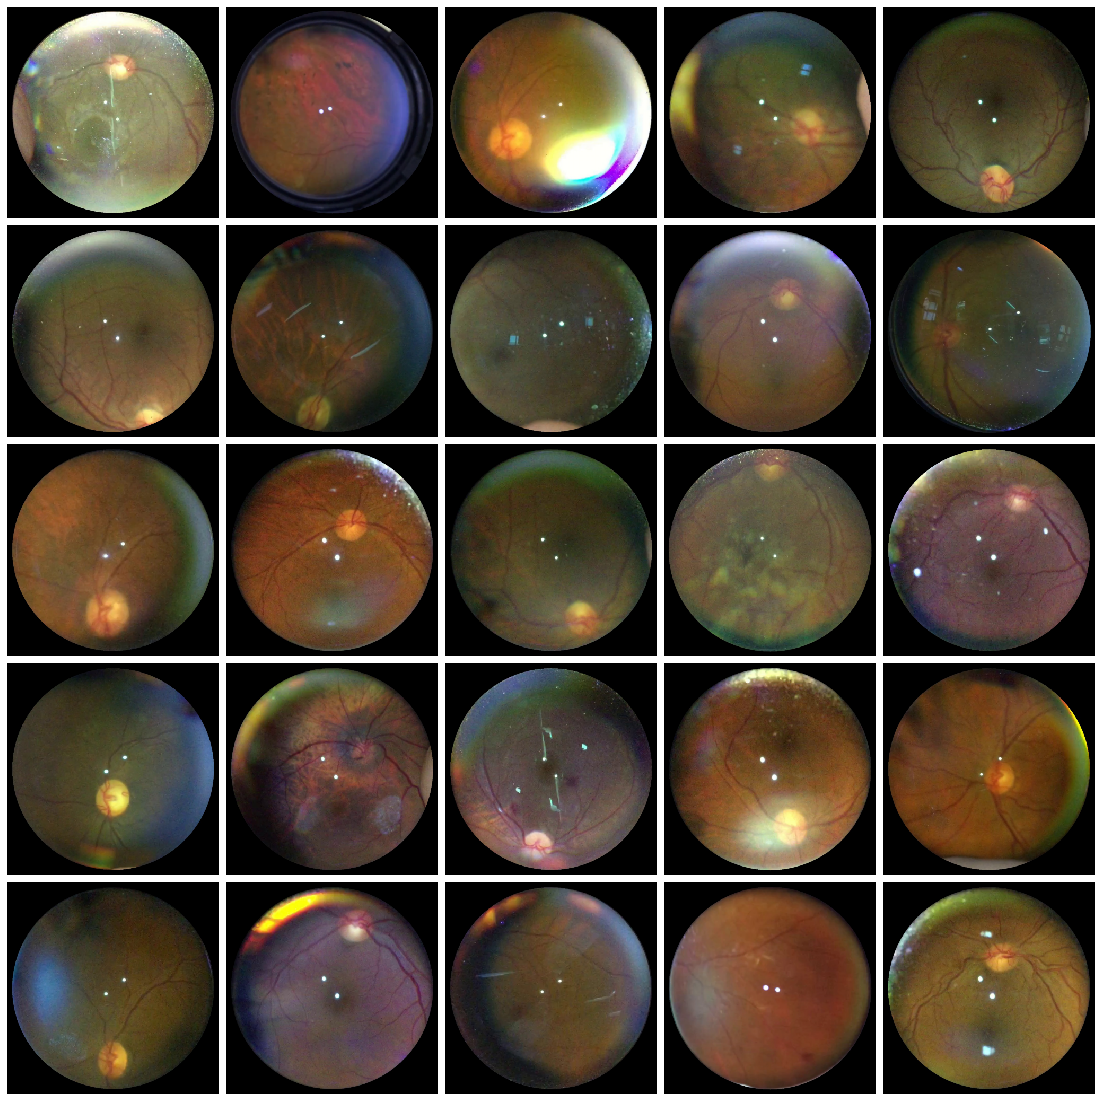

In [107]:
image_paths = listdir(BASE_PATH)
random.shuffle(image_paths)
samples = prepare_dataset(image_paths, NUM_TRAIN_SAMPLES, size='small')


draw_image_grid(samples, clahe=True)

In [108]:
#for n in range(3, 8):
#    model, bic, aic = segment_images(samples, 3)
#    print(n, aic, bic)
#images = predict_images(samples, model)

In [109]:
model, bic, aic = segment_images(samples, 4)

WRAP> Function segment_images needed 12.29 seconds to execute!


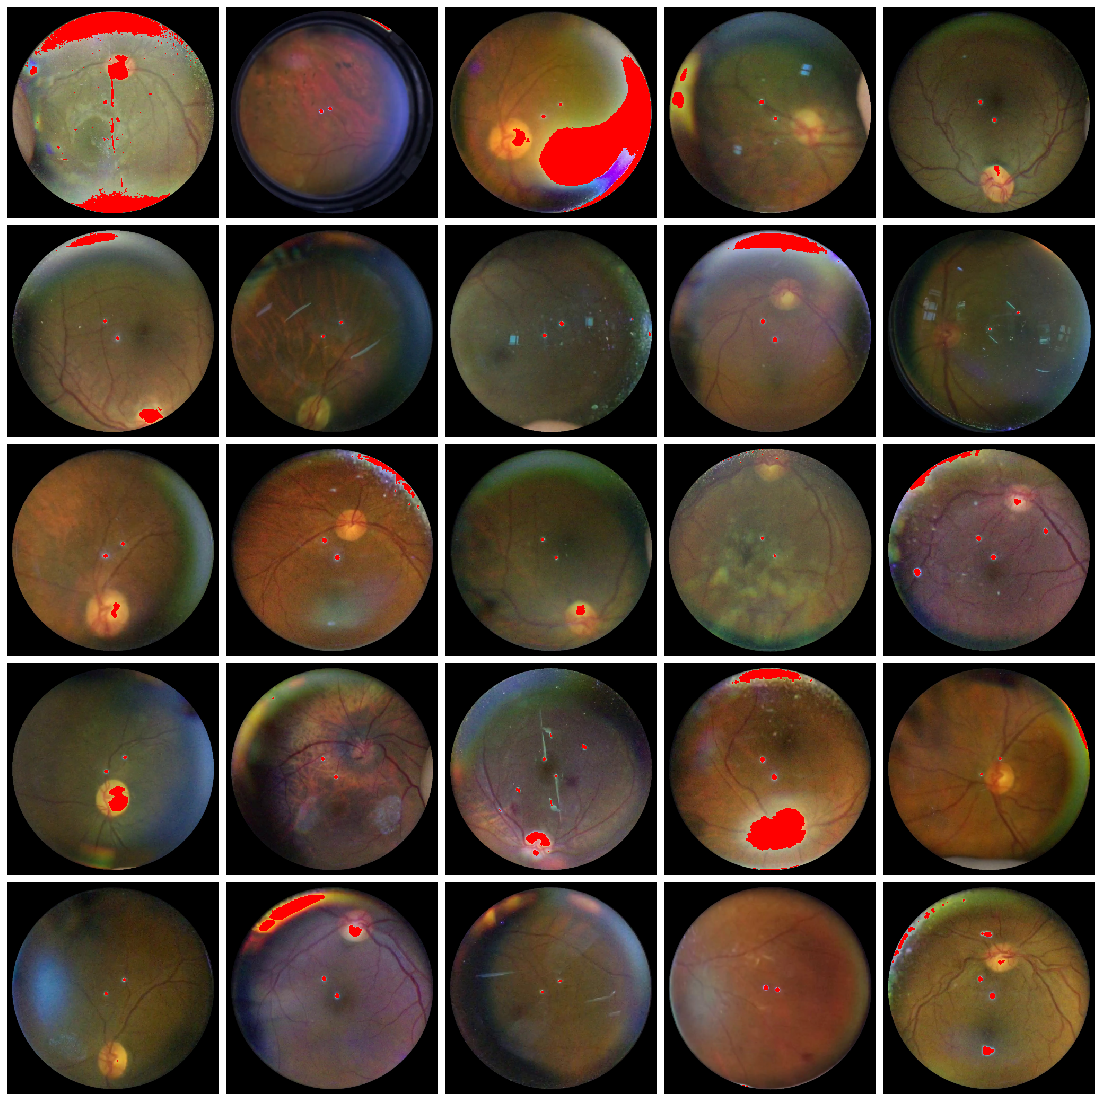

In [110]:
lbls = predict_images(samples, model)
results = []
for lbl_img, img in zip(lbls, samples):
    mask = (lbl_img == 2)
    res = img.copy()
    res[np.where(mask)] = [1.0, 0, 0]
    # res = cv2.inpaint(img_as_ubyte(res), img_as_ubyte(mask), 3, cv2.INPAINT_TELEA)
    results.append(res)
draw_image_grid(results, clahe=True)

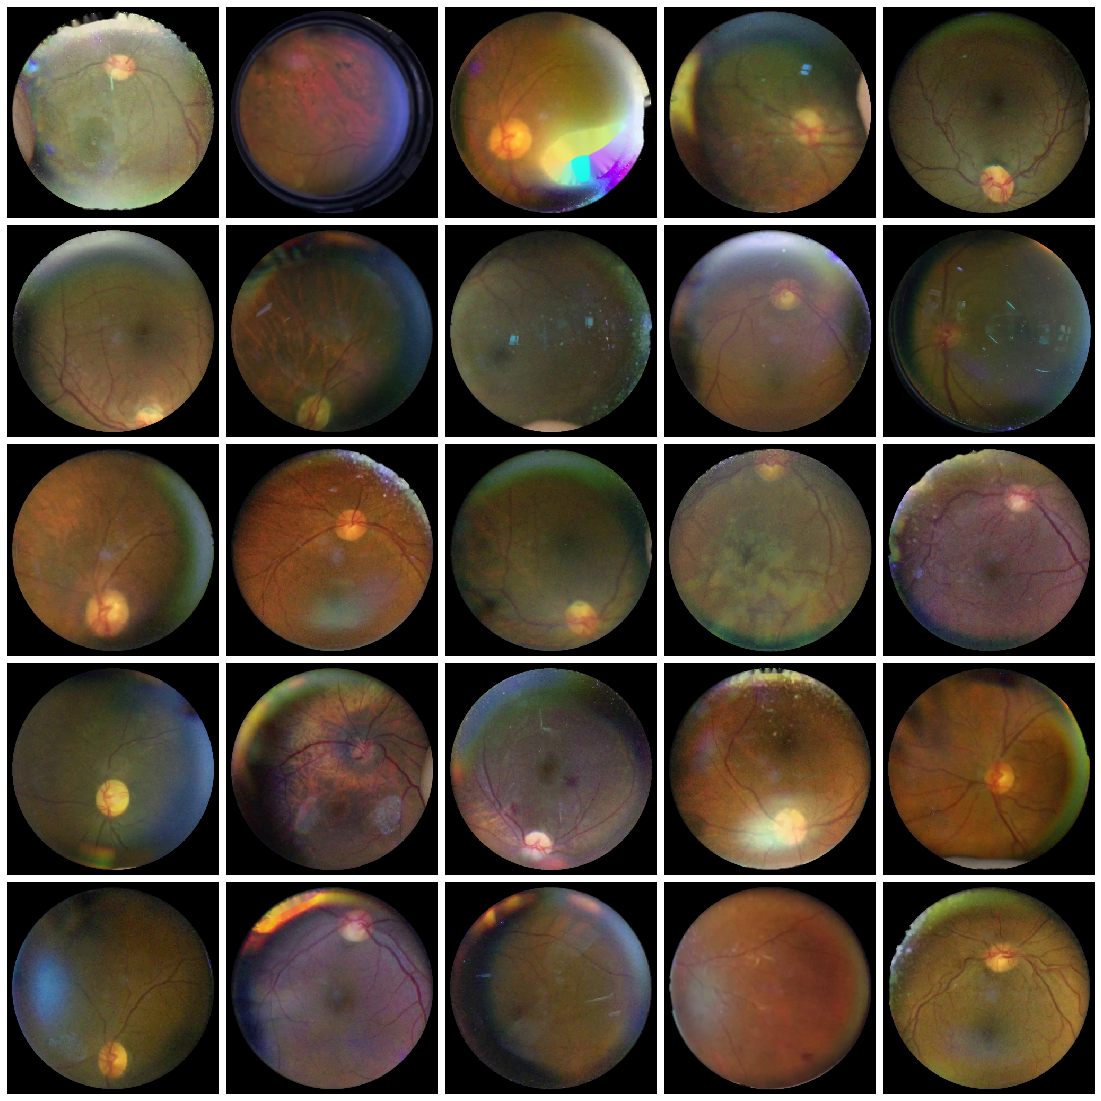

(400, 400, 3) uint8 253


In [123]:
results = []
for img in samples:
    img2 = exposure.equalize_adapthist(img.copy(), clip_limit=0.04)
    img2 = img2[:, :, 1]
    
    mask = img2 > 0.85
    mask = morphology.dilation(mask, morphology.disk(3))
    
    #img[mask] = [0, 0, 0]
    results.append(cv2.inpaint(img_as_ubyte(img), img_as_ubyte(mask), 3, cv2.INPAINT_TELEA))

draw_image_grid(results, clahe=False)
print(results[0].shape, results[0].dtype, results[0].max())
